# Hodgkin-Huxley models

## Classical H-H model

Im = Cm(dV/dt) + ḡNa × m³ × h × (V - ENa) + ḡK × n⁴ × (V - EK) + gL × (V - EL)

Constant (initialization) parameters (known):
- Cm(dV/dt) - Capacitive current 
- Cm: Membrane capacitance (typically 1 μF/cm²) [For capacitors: I = C × (dV/dt)]
- ḡNa: Maximum sodium conductance (typically 120 mS/cm²)
- ḡK: Maximum potassium conductance (typically 36 mS/cm²)
- gL: Leak conductance (typically 0.3 mS/cm²)
- ENa: Sodium reversal potential (typically +50 mV)
- EK: Potassium reversal potential (typically -77 mV)
- EL: Leak reversal potential (typically -54.4 mV)
- m³ and  n⁴ = probability of ion gate being open
- h voltage gated inactivation gate
- L is the passive leakage ion channel

State Variables (unknown at each step apart from initialization):
- V: Membrane potential (initialize at resting potential, typically -65 mV)
- m: Sodium activation gating variable (initialize at steady-state value)
- h: Sodium inactivation gating variable (initialize at steady-state value)
- n: Potassium activation gating variable (initialize at steady-state value)

Time-related variables (known):
- dt: Time step for numerical integration
- t: Current simulation time
- tmax: Maximum simulation time


Algorithm:

1. Compute voltage-dependent rate constants (alpha_m, beta_m, alpha_h, beta_h, alpha_n, beta_n)
   - αm(V), βm(V) for sodium activation
     - αm(V) = 0.1 * (V + 40) / (1 - exp(-(V + 40) / 10))
     - βm(V) = 4.0 * exp(-(V + 65) / 18)
   - αh(V), βh(V) for sodium inactivation
     - αh(V) = 0.07 * exp(-(V + 65) / 20)
     - βh(V) = 1.0 / (1 + exp(-(V + 35) / 10))
   - αn(V), βn(V) for potassium activation
     - αn(V) = 0.01 * (V + 55) / (1 - exp(-(V + 55) / 10))
     - βn(V) = 0.125 * exp(-(V + 65) / 80)
  
2. Update gating variables (m, h, n) based on these rate constants
   
3. Compute conductances using the gating variables (g_Na = g_Na_max * m³ * h, g_K = g_K_max * n⁴)
   - dm/dt = αm(V)*(1-m) - βm(V)*m
   - dh/dt = αh(V)*(1-h) - βh(V)*h
   - dn/dt = αn(V)*(1-n) - βn(V)*n
  
4. Compute sodium, potassium, and leak currents using these conductances
   - I_Na = g_Na * (V - E_Na)
   - I_K = g_K * (V - E_K)
   - I_L = g_L * (V - E_L)
5. Compute total membrane current (I_total = I_ext - I_Na - I_K - I_L)
   
6. Compute change in membrane potential (dV/dt = I_total / Cm)
    - dV/dt = I_total/ Cm

7. Update membrane potential using numerical integration
   - V = V + dV/dt * dt
   - m = m + dm/dt * dt
   - h = h + dh/dt * dt
   - n = n + dn/dt * dt
   
8. Repeat steps 1-7 for each time step

### Implementation

In [11]:
import numpy as np
# 1. Computing voltage dependant params
class Classic_HH:
    def __init__(self, 
                 Cm=1.0,                # Membrane capacitance (μF/cm²)
                 g_Na=120.0,            # Maximum sodium conductance (mS/cm²)
                 g_K=36.0,              # Maximum potassium conductance (mS/cm²)
                 g_L=0.3,               # Leak conductance (mS/cm²)
                 E_Na=50.0,             # Sodium reversal potential (mV)
                 E_K=-77.0,             # Potassium reversal potential (mV)
                 E_L=-54.4,             # Leak reversal potential (mV)
                 V_rest=-65.0):         # Resting membrane potential (mV)
        
        # Membrane properties
        self.Cm = Cm
        self.g_Na = g_Na
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        
        # State variables
        self.V = V_rest
        
        # Initialize gating variables to steady-state values at resting potential
        self.m = self.m_inf(V_rest)
        self.h = self.h_inf(V_rest)
        self.n = self.n_inf(V_rest)
    
    # Voltage-dependent rate constants for sodium activation (m)
    def alpha_m(self, V):
        return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    
    def beta_m(self, V):
        return 4.0 * np.exp(-(V + 65) / 18)
    
    # Voltage-dependent rate constants for sodium inactivation (h)
    def alpha_h(self, V):
        return 0.07 * np.exp(-(V + 65) / 20)
    
    def beta_h(self, V):
        return 1.0 / (1 + np.exp(-(V + 35) / 10))
    
    # Voltage-dependent rate constants for potassium activation (n)
    def alpha_n(self, V):
        return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    
    def beta_n(self, V):
        return 0.125 * np.exp(-(V + 65) / 80)
    
    # Steady-state values for gating variables
    def m_inf(self, V):
        alpha = self.alpha_m(V)
        beta = self.beta_m(V)
        return alpha / (alpha + beta)
    
    def h_inf(self, V):
        alpha = self.alpha_h(V)
        beta = self.beta_h(V)
        return alpha / (alpha + beta)
    
    def n_inf(self, V):
        alpha = self.alpha_n(V)
        beta = self.beta_n(V)
        return alpha / (alpha + beta)
    
    # Time constants for gating variables
    def tau_m(self, V):
        alpha = self.alpha_m(V)
        beta = self.beta_m(V)
        return 1.0 / (alpha + beta)
    
    def tau_h(self, V):
        alpha = self.alpha_h(V)
        beta = self.beta_h(V)
        return 1.0 / (alpha + beta)
    
    def tau_n(self, V):
        alpha = self.alpha_n(V)
        beta = self.beta_n(V)
        return 1.0 / (alpha + beta)
    
    # Ionic currents
    def I_Na(self, V, m, h):
        return self.g_Na * m**3 * h * (V - self.E_Na)
    
    def I_K(self, V, n):
        return self.g_K * n**4 * (V - self.E_K)
    
    def I_L(self, V):
        return self.g_L * (V - self.E_L)
    
    # Derivatives of state variables
    def dVdt(self, V, m, h, n, I_ext=0.0):
        I_Na = self.I_Na(V, m, h)
        I_K = self.I_K(V, n)
        I_L = self.I_L(V)
        return (I_ext - I_Na - I_K - I_L) / self.Cm
    
    def dmdt(self, V, m):
        return self.alpha_m(V) * (1 - m) - self.beta_m(V) * m
    
    def dhdt(self, V, h):
        return self.alpha_h(V) * (1 - h) - self.beta_h(V) * h
    
    def dndt(self, V, n):
        return self.alpha_n(V) * (1 - n) - self.beta_n(V) * n
    
    # Update state variables using Euler method
    def update(self, dt, I_ext=0.0):
        # Calculate derivatives
        dV = self.dVdt(self.V, self.m, self.h, self.n, I_ext) * dt
        dm = self.dmdt(self.V, self.m) * dt
        dh = self.dhdt(self.V, self.h) * dt
        dn = self.dndt(self.V, self.n) * dt
        
        # Update state variables
        self.V += dV
        self.m += dm
        self.h += dh
        self.n += dn
        
        return self.V, self.m, self.h, self.n
    
    # Run simulation for a given time with specified stimulus
    def simulate(self, t_max, dt, I_ext_func=None):
        """
        Run the simulation for t_max milliseconds with time step dt.
        
        Parameters:
        -----------
        t_max : float
            Maximum simulation time in milliseconds
        dt : float
            Time step for numerical integration in milliseconds
        I_ext_func : callable, optional
            Function that takes time as input and returns external current
            
        Returns:
        --------
        tuple
            (time_points, V, m, h, n) arrays containing simulation results
        """
        n_steps = int(t_max / dt)
        time_points = np.arange(0, t_max, dt)
        
        # Arrays to store results
        V_trace = np.zeros(n_steps)
        m_trace = np.zeros(n_steps)
        h_trace = np.zeros(n_steps)
        n_trace = np.zeros(n_steps)
        
        # Initial values
        V_trace[0] = self.V
        m_trace[0] = self.m
        h_trace[0] = self.h
        n_trace[0] = self.n
        
        # Simulation loop
        for i in range(1, n_steps):
            t = time_points[i]
            I_ext = I_ext_func(t) if I_ext_func is not None else 0.0
            
            # Update state variables
            V, m, h, n = self.update(dt, I_ext)
            
            # Store results
            V_trace[i] = V
            m_trace[i] = m
            h_trace[i] = h
            n_trace[i] = n
        
        return time_points, V_trace, m_trace, h_trace, n_trace

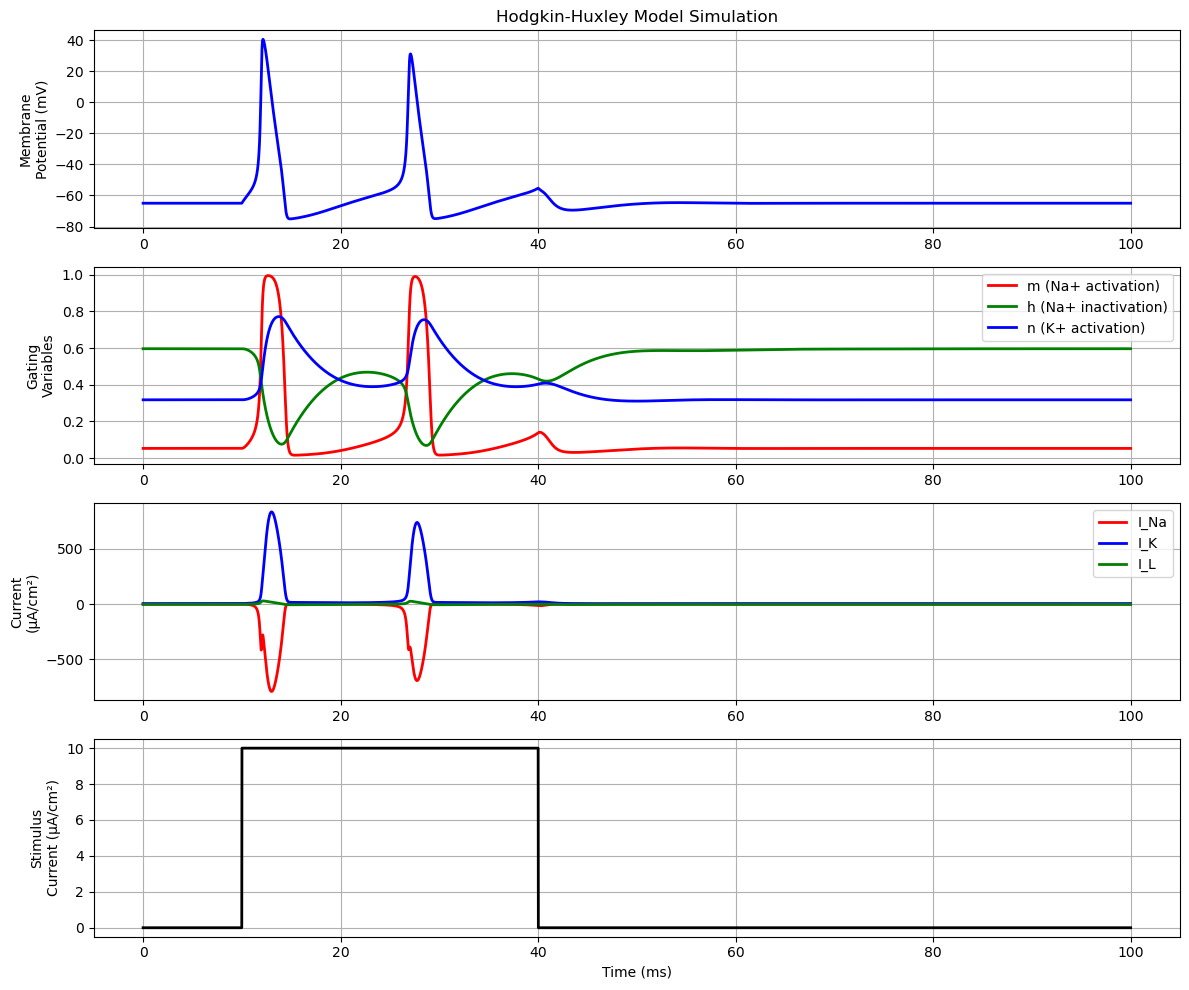

Resting Membrane Potential: -65.00 mV
Action Potential Peak: 40.54 mV
Action Potential Amplitude: 105.54 mV


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create an instance of our Hodgkin-Huxley model
hh = Classic_HH()

# Define a step current stimulus function
def step_current(t):
    # Apply a 10 μA/cm² current from t=10ms to t=40ms
    if 10 <= t <= 40:
        return 10.0
    return 0.0

# Run the simulation
t_max = 100  # Maximum simulation time (ms)
dt = 0.01    # Time step for integration (ms)
time, V, m, h, n = hh.simulate(t_max, dt, I_ext_func=step_current)

# Calculate the currents for plotting
I_Na = np.zeros_like(time)
I_K = np.zeros_like(time)
I_L = np.zeros_like(time)
I_stim = np.zeros_like(time)

for i in range(len(time)):
    I_Na[i] = hh.I_Na(V[i], m[i], h[i])
    I_K[i] = hh.I_K(V[i], n[i])
    I_L[i] = hh.I_L(V[i])
    I_stim[i] = step_current(time[i])

# Create a figure with multiple subplots
plt.figure(figsize=(12, 10))

# Plot 1: Membrane potential
plt.subplot(4, 1, 1)
plt.plot(time, V, 'b', linewidth=2)
plt.title('Hodgkin-Huxley Model Simulation')
plt.ylabel('Membrane\nPotential (mV)')
plt.grid(True)

# Plot 2: Gating variables
plt.subplot(4, 1, 2)
plt.plot(time, m, 'r', label='m (Na+ activation)', linewidth=2)
plt.plot(time, h, 'g', label='h (Na+ inactivation)', linewidth=2)
plt.plot(time, n, 'b', label='n (K+ activation)', linewidth=2)
plt.ylabel('Gating\nVariables')
plt.legend(loc='upper right')
plt.grid(True)

# Plot 3: Ionic currents
plt.subplot(4, 1, 3)
plt.plot(time, I_Na, 'r', label='I_Na', linewidth=2)
plt.plot(time, I_K, 'b', label='I_K', linewidth=2)
plt.plot(time, I_L, 'g', label='I_L', linewidth=2)
plt.ylabel('Current\n(μA/cm²)')
plt.legend(loc='upper right')
plt.grid(True)

# Plot 4: Stimulus current
plt.subplot(4, 1, 4)
plt.plot(time, I_stim, 'k', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Stimulus\nCurrent (μA/cm²)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Display some key metrics
action_potential_peak = np.max(V)
resting_potential = V[0]
print(f"Resting Membrane Potential: {resting_potential:.2f} mV")
print(f"Action Potential Peak: {action_potential_peak:.2f} mV")
print(f"Action Potential Amplitude: {action_potential_peak - resting_potential:.2f} mV")

---

Im = Cm(∂V/∂t) + ḡNa × m³ × h × (V - ENa) + ḡK × n⁴ × (V - EK) + gL × (V - EL)

# H-H Cable model (unmyelinated)
∂V/∂t = (1/Cm) × [a/(2*Ra) × (∂²V/∂x²) - Im + Iext]

Constant (initialization) parameters (known):
- Cm: Membrane capacitance (typically 1 μF/cm²)
- ḡNa: Maximum sodium conductance (typically 120 mS/cm²)
- ḡK: Maximum potassium conductance (typically 36 mS/cm²)
- gL: Leak conductance (typically 0.3 mS/cm²)
- ENa: Sodium reversal potential (typically +50 mV)
- EK: Potassium reversal potential (typically -77 mV)
- EL: Leak reversal potential (typically -54.4 mV)
- Ra: Axial resistance (typically 100-200 Ω·cm)
- a: Fiber radius (μm)
- L: Total length of cable (μm)
- dx: Spatial step size (μm)

State Variables (unknown at each point in space and time):
- V(x,t): Membrane potential at position x and time t (initialize at resting potential)
- m(x,t): Sodium activation gating variable at position x and time t
- h(x,t): Sodium inactivation gating variable at position x and time t
- n(x,t): Potassium activation gating variable at position x and time t

Time-related variables:
- dt: Time step for numerical integration
- t: Current simulation time
- tmax: Maximum simulation time

Space-related variables:
- x: Position along axon (0 to L)
- N: Number of compartments (L/dx)

Algorithm:

1. Initialize the model:
   - Discretize the cable into N compartments
   - Set initial values for V, m, h, n at each compartment
   - Typically V = Vrest, and m, h, n at their steady-state values for Vrest

2. For each time step:
   
   For each compartment i from 0 to N-1:
   
   a. Compute voltage-dependent rate constants at position i
      - αm(V[i]), βm(V[i]) for sodium activation
        - αm(V) = 0.1 * (V + 40) / (1 - exp(-(V + 40) / 10))
        - βm(V) = 4.0 * exp(-(V + 65) / 18)
      - αh(V[i]), βh(V[i]) for sodium inactivation
        - αh(V) = 0.07 * exp(-(V + 65) / 20)
        - βh(V) = 1.0 / (1 + exp(-(V + 35) / 10))
      - αn(V[i]), βn(V[i]) for potassium activation
        - αn(V) = 0.01 * (V + 55) / (1 - exp(-(V + 55) / 10))
        - βn(V) = 0.125 * exp(-(V + 65) / 80)
   
   b. Calculate derivatives of gating variables at position i
      - dm[i]/dt = αm(V[i])*(1-m[i]) - βm(V[i])*m[i]
      - dh[i]/dt = αh(V[i])*(1-h[i]) - βh(V[i])*h[i]
      - dn[i]/dt = αn(V[i])*(1-n[i]) - βn(V[i])*n[i]
   
   c. Compute ionic currents at position i
      - I_Na[i] = ḡNa * m[i]³ * h[i] * (V[i] - ENa)
      - I_K[i] = ḡK * n[i]⁴ * (V[i] - EK)
      - I_L[i] = gL * (V[i] - EL)
      - I_ion[i] = I_Na[i] + I_K[i] + I_L[i]
   
   d. Compute axial (longitudinal) currents using the cable equation
      - For internal compartments (i = 1 to N-2):
        - I_axial[i] = (a/(2*Ra)) * ((V[i+1] - V[i])/dx² - (V[i] - V[i-1])/dx²)
        - This is equivalent to: I_axial[i] = (a/(2*Ra*dx²)) * (V[i+1] - 2*V[i] + V[i-1])
      
      - For boundary compartments:
        - Apply appropriate boundary conditions (sealed end, current clamp, voltage clamp, etc.)
        - For sealed ends (no current flow): I_axial[0] = (a/(2*Ra*dx²)) * (V[1] - V[0])
                                            I_axial[N-1] = (a/(2*Ra*dx²)) * (V[N-2] - V[N-1])
   
   e. Compute membrane potential derivative at position i
      - dV[i]/dt = (1/Cm) * (I_axial[i] - I_ion[i] + I_ext[i,t])
   
   f. Update all state variables using numerical integration
      - V[i] = V[i] + dV[i]/dt * dt
      - m[i] = m[i] + dm[i]/dt * dt
      - h[i] = h[i] + dh[i]/dt * dt
      - n[i] = n[i] + dn[i]/dt * dt

3. Repeat step 2, incrementing time by dt, until t = tmax

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

class HH_Cable:
    def __init__(self, 
                 L=1000.0,           # Length of cable (μm)
                 a=10.0,             # Radius of cable (μm)
                 dx=10.0,            # Spatial step size (μm)
                 Cm=1.0,             # Membrane capacitance (μF/cm²)
                 g_Na=120.0,         # Maximum sodium conductance (mS/cm²)
                 g_K=36.0,           # Maximum potassium conductance (mS/cm²)
                 g_L=0.3,            # Leak conductance (mS/cm²)
                 E_Na=50.0,          # Sodium reversal potential (mV)
                 E_K=-77.0,          # Potassium reversal potential (mV)
                 E_L=-54.4,          # Leak reversal potential (mV)
                 Ra=100.0,           # Axial resistance (Ω·cm)
                 V_rest=-65.0):      # Resting membrane potential (mV)
        
        # Cable properties
        self.L = L
        self.a = a
        self.dx = dx
        self.Ra = Ra
        
        # Membrane properties
        self.Cm = Cm
        self.g_Na = g_Na
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        
        # Discretize the cable
        self.N = int(L / dx) + 1  # Number of compartments
        self.x = np.linspace(0, L, self.N)  # Spatial positions
        
        # Initialize state variables
        self.V = np.ones(self.N) * V_rest
        
        # Initialize gating variables to steady-state values at resting potential
        self.m = np.ones(self.N) * self.m_inf(V_rest)
        self.h = np.ones(self.N) * self.h_inf(V_rest)
        self.n = np.ones(self.N) * self.n_inf(V_rest)
        
        # Storage for recording state variables during simulation
        self.V_history = None
        self.m_history = None
        self.h_history = None
        self.n_history = None
        self.t_array = None
        
    # Voltage-dependent rate constants for sodium activation (m)
    def alpha_m(self, V):
        return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    
    def beta_m(self, V):
        return 4.0 * np.exp(-(V + 65) / 18)
    
    # Voltage-dependent rate constants for sodium inactivation (h)
    def alpha_h(self, V):
        return 0.07 * np.exp(-(V + 65) / 20)
    
    def beta_h(self, V):
        return 1.0 / (1 + np.exp(-(V + 35) / 10))
    
    # Voltage-dependent rate constants for potassium activation (n)
    def alpha_n(self, V):
        return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    
    def beta_n(self, V):
        return 0.125 * np.exp(-(V + 65) / 80)
    
    # Steady-state values for gating variables
    def m_inf(self, V):
        alpha = self.alpha_m(V)
        beta = self.beta_m(V)
        return alpha / (alpha + beta)
    
    def h_inf(self, V):
        alpha = self.alpha_h(V)
        beta = self.beta_h(V)
        return alpha / (alpha + beta)
    
    def n_inf(self, V):
        alpha = self.alpha_n(V)
        beta = self.beta_n(V)
        return alpha / (alpha + beta)
    
    # Time constants for gating variables
    def tau_m(self, V):
        alpha = self.alpha_m(V)
        beta = self.beta_m(V)
        return 1.0 / (alpha + beta)
    
    def tau_h(self, V):
        alpha = self.alpha_h(V)
        beta = self.beta_h(V)
        return 1.0 / (alpha + beta)
    
    def tau_n(self, V):
        alpha = self.alpha_n(V)
        beta = self.beta_n(V)
        return 1.0 / (alpha + beta)
    
    # Ionic currents
    def I_Na(self, V, m, h):
        return self.g_Na * m**3 * h * (V - self.E_Na)
    
    def I_K(self, V, n):
        return self.g_K * n**4 * (V - self.E_K)
    
    def I_L(self, V):
        return self.g_L * (V - self.E_L)
    
    # Total ionic current
    def I_ion(self, V, m, h, n):
        return self.I_Na(V, m, h) + self.I_K(V, n) + self.I_L(V)
    
    # Axial current calculation (second spatial derivative)
    def I_axial(self, V):
        # Conversion factor from μm to cm (Ra and other parameters are in cm)
        conversion = 1e-4  # 1 μm = 1e-4 cm
        
        # Calculate the factor for the axial current
        factor = self.a * conversion / (2 * self.Ra)
        
        # Initialize the axial current array
        I_ax = np.zeros_like(V)
        
        # Calculate second derivative using finite differences
        # For internal compartments
        for i in range(1, self.N - 1):
            I_ax[i] = factor * (V[i+1] - 2*V[i] + V[i-1]) / (self.dx * conversion)**2
        
        # For boundary compartments (using sealed-end boundary conditions)
        I_ax[0] = factor * 2 * (V[1] - V[0]) / (self.dx * conversion)**2
        I_ax[-1] = factor * 2 * (V[-2] - V[-1]) / (self.dx * conversion)**2
        
        return I_ax
    
    # Derivatives of state variables
    def dVdt(self, V, m, h, n, I_ext):
        I_ax = self.I_axial(V)
        I_ion_values = self.I_ion(V, m, h, n)
        return (I_ax - I_ion_values + I_ext) / self.Cm
    
    def dmdt(self, V, m):
        alpha_m = self.alpha_m(V)
        beta_m = self.beta_m(V)
        return alpha_m * (1 - m) - beta_m * m
    
    def dhdt(self, V, h):
        alpha_h = self.alpha_h(V)
        beta_h = self.beta_h(V)
        return alpha_h * (1 - h) - beta_h * h
    
    def dndt(self, V, n):
        alpha_n = self.alpha_n(V)
        beta_n = self.beta_n(V)
        return alpha_n * (1 - n) - beta_n * n
    
    # Update state variables using Euler method
    def update(self, dt, I_ext):
        # Calculate derivatives
        dV = self.dVdt(self.V, self.m, self.h, self.n, I_ext) * dt
        dm = self.dmdt(self.V, self.m) * dt
        dh = self.dhdt(self.V, self.h) * dt
        dn = self.dndt(self.V, self.n) * dt
        
        # Update state variables
        self.V += dV
        self.m += dm
        self.h += dh
        self.n += dn
    
    # Run simulation for a given time with specified stimulus
    def simulate(self, t_max, dt, I_ext_func=None, record_interval=1):
        """
        Run the simulation for t_max milliseconds with time step dt.
        
        Parameters:
        -----------
        t_max : float
            Maximum simulation time in milliseconds
        dt : float
            Time step for numerical integration in milliseconds
        I_ext_func : callable, optional
            Function that takes time and position as input and returns external current
            If None, no external current is applied
        record_interval : int, optional
            Record state variables every record_interval time steps
            
        Returns:
        --------
        tuple
            (time_points, x_positions, V_history, m_history, h_history, n_history)
            Arrays containing simulation results
        """
        n_steps = int(t_max / dt)
        n_record = int(n_steps / record_interval) + 1
        
        # Initialize arrays to store results
        self.t_array = np.linspace(0, t_max, n_record)
        self.V_history = np.zeros((n_record, self.N))
        self.m_history = np.zeros((n_record, self.N))
        self.h_history = np.zeros((n_record, self.N))
        self.n_history = np.zeros((n_record, self.N))
        
        # Record initial state
        self.V_history[0] = self.V.copy()
        self.m_history[0] = self.m.copy()
        self.h_history[0] = self.h.copy()
        self.n_history[0] = self.n.copy()
        
        # Simulation loop
        record_idx = 1
        for step in range(1, n_steps + 1):
            t = step * dt
            
            # Determine external current
            if I_ext_func is None:
                I_ext = np.zeros(self.N)
            else:
                I_ext = np.array([I_ext_func(t, x_pos) for x_pos in self.x])
            
            # Update state variables
            self.update(dt, I_ext)
            
            # Record state variables at specified intervals
            if step % record_interval == 0:
                self.V_history[record_idx] = self.V.copy()
                self.m_history[record_idx] = self.m.copy()
                self.h_history[record_idx] = self.h.copy()
                self.n_history[record_idx] = self.n.copy()
                record_idx += 1
        
        return self.t_array, self.x, self.V_history, self.m_history, self.h_history, self.n_history
    
    # Method to visualize the simulation results as a heatmap
    def plot_voltage_heatmap(self, cmap='viridis', vmin=None, vmax=None):
        """
        Plot the membrane potential as a heatmap (space vs time).
        
        Parameters:
        -----------
        cmap : str
            Colormap name
        vmin, vmax : float, optional
            Minimum and maximum values for colormap scaling
        """
        if self.V_history is None:
            raise ValueError("No simulation data available. Run simulate() first.")
        
        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Set default vmin and vmax if not provided
        if vmin is None:
            vmin = np.min(self.V_history)
        if vmax is None:
            vmax = np.max(self.V_history)
        
        # Create heatmap
        im = ax.imshow(
            self.V_history.T,  # Transpose to have space on y-axis and time on x-axis
            aspect='auto',
            origin='lower',
            extent=[0, self.t_array[-1], 0, self.L],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax
        )
        
        # Add labels and title
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Position (μm)')
        ax.set_title('Membrane Potential Propagation')
        
        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('Membrane Potential (mV)')
        
        return fig, ax
    
    # Method to create an animation of the action potential propagation
    def animate_propagation(self, interval=50, cmap='viridis', vmin=None, vmax=None):
        """
        Create an animation of the action potential propagation.
        
        Parameters:
        -----------
        interval : int
            Time between frames in milliseconds
        cmap : str
            Colormap name
        vmin, vmax : float, optional
            Minimum and maximum values for y-axis scaling
        
        Returns:
        --------
        matplotlib.animation.FuncAnimation
            Animation object
        """
        if self.V_history is None:
            raise ValueError("No simulation data available. Run simulate() first.")
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Set default vmin and vmax if not provided
        if vmin is None:
            vmin = np.min(self.V_history)
        if vmax is None:
            vmax = np.max(self.V_history)
        
        # Initial plot
        line, = ax.plot(self.x, self.V_history[0], 'b-', lw=2)
        
        # Set axis limits
        ax.set_xlim(0, self.L)
        ax.set_ylim(vmin, vmax)
        
        # Add labels and title
        ax.set_xlabel('Position (μm)')
        ax.set_ylabel('Membrane Potential (mV)')
        title = ax.set_title(f'Time: {self.t_array[0]:.2f} ms')
        
        # Add grid
        ax.grid(True)
        
        # Function to update the plot for each frame
        def update(frame):
            line.set_ydata(self.V_history[frame])
            title.set_text(f'Time: {self.t_array[frame]:.2f} ms')
            return line, title
        
        # Create animation
        ani = FuncAnimation(
            fig, update, frames=len(self.t_array),
            interval=interval, blit=True
        )
        
        return ani

Running simulation...
Simulation complete!
Generating voltage heatmap...


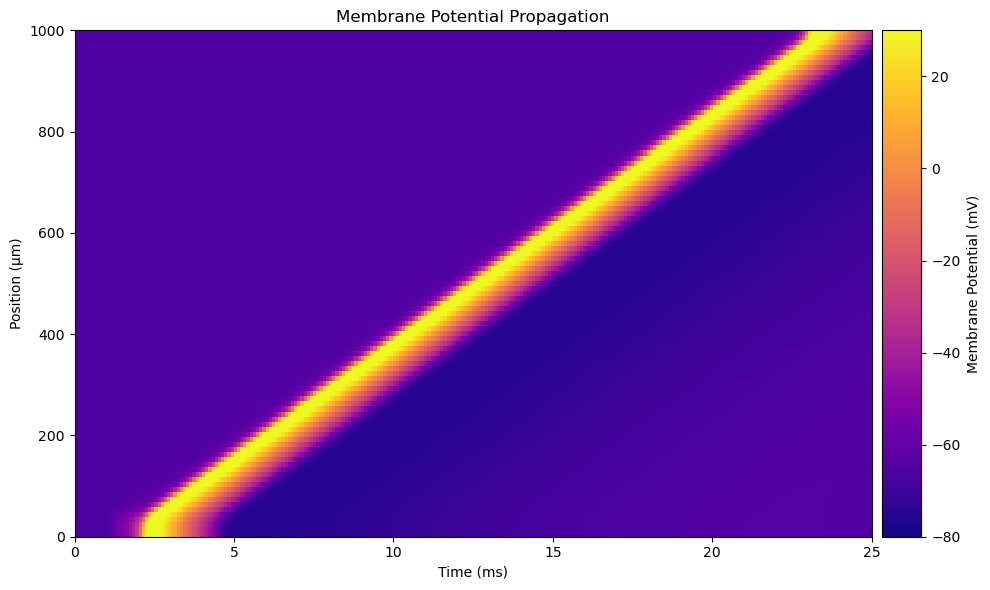

Generating voltage snapshots...


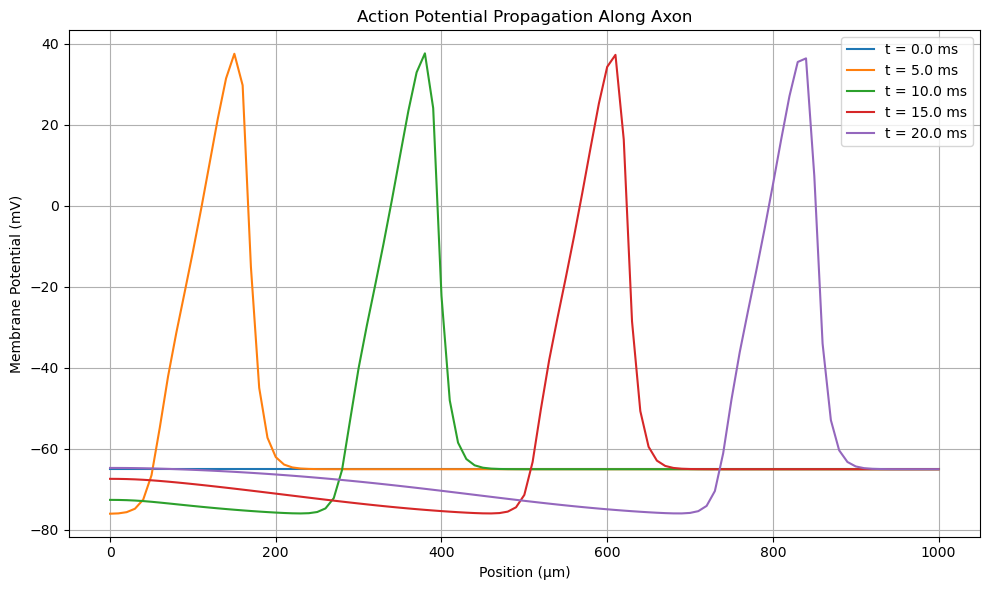

Calculating action potential propagation velocity...
Action potential propagation velocity: 0.05 m/s


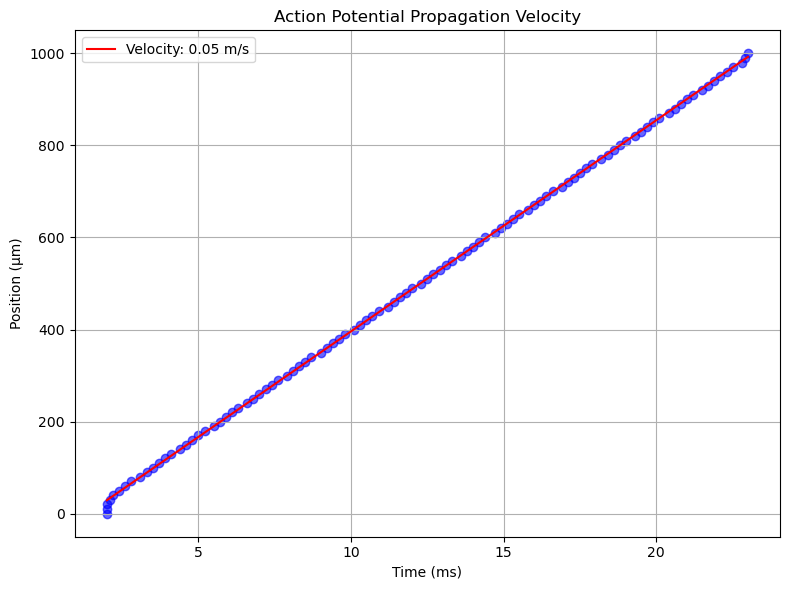

Done!


In [20]:

# Running a simulation and visualize the results

# Create a cable model
cable = HH_Cable(
    L=1000.0,    # 1000 μm = 1 mm length
    a=10.0,      # 10 μm radius
    dx=10.0,     # 10 μm spatial step
    Ra=100.0     # 100 Ω·cm axial resistance
)

# Define a stimulus function that applies current at one end of the cable
def stimulus(t, x):
    # Apply a 30 μA/cm² current pulse at the start of the cable
    # from t=1ms to t=2ms only at the first 50 μm
    if 1 <= t <= 2 and x < 50:
        return 30.0
    return 0.0

# Run the simulation
print("Running simulation...")
t_array, x_pos, V_history, m_history, h_history, n_history = cable.simulate(
    t_max=25.0,     # Simulate for 25 ms
    dt=0.01,        # Time step of 0.01 ms
    I_ext_func=stimulus,
    record_interval=10  # Record every 10 time steps to save memory
)
print("Simulation complete!")

# Plot the voltage heatmap
print("Generating voltage heatmap...")
fig, ax = cable.plot_voltage_heatmap(
    cmap='plasma',
    vmin=-80,
    vmax=30
)
plt.tight_layout()
plt.savefig('hh_cable_voltage_heatmap.png', dpi=150)
plt.show()

# Plot snapshots of the membrane potential at different times
print("Generating voltage snapshots...")
plt.figure(figsize=(10, 6))
snapshot_times = [0, 5, 10, 15, 20]  # ms
for t_idx, t_val in enumerate(snapshot_times):
    # Find closest time index
    t_idx = np.argmin(np.abs(t_array - t_val))
    plt.plot(x_pos, V_history[t_idx], label=f't = {t_array[t_idx]:.1f} ms')

plt.xlabel('Position (μm)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Action Potential Propagation Along Axon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('hh_cable_voltage_snapshots.png', dpi=150)
plt.show()

# Extract action potential velocity
print("Calculating action potential propagation velocity...")
# Find the time when each position reaches threshold (0 mV)
threshold = 0  # mV
crossing_times = np.zeros(cable.N)

for i in range(cable.N):
    # Find all times when this position crosses threshold
    crossings = np.where(np.diff(V_history[:, i] > threshold))[0]
    # If there are crossings, record the first one
    if len(crossings) > 0:
        crossing_times[i] = t_array[crossings[0]]

# Calculate velocity from positions that had action potentials
valid_positions = (crossing_times > 0)
if np.sum(valid_positions) > 10:  # Ensure we have enough points
    # Get positions and times
    x_vals = x_pos[valid_positions]
    t_vals = crossing_times[valid_positions]
    
    # Fit a line to estimate velocity
    # Velocity = distance/time = 1/slope
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(t_vals, x_vals)
    
    # Convert to m/s (from μm/ms)
    velocity = slope * 1e-3  # m/s
    
    print(f"Action potential propagation velocity: {velocity:.2f} m/s")
    
    # Plot the positions vs crossing times
    plt.figure(figsize=(8, 6))
    plt.scatter(t_vals, x_vals, c='blue', alpha=0.6)
    plt.plot(t_vals, intercept + slope*t_vals, 'r-', 
             label=f'Velocity: {velocity:.2f} m/s')
    plt.xlabel('Time (ms)')
    plt.ylabel('Position (μm)')
    plt.title('Action Potential Propagation Velocity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('hh_cable_velocity.png', dpi=150)
    plt.show()
else:
    print("Not enough action potential propagation to calculate velocity")

print("Done!")